In [1]:
!pip install -q tensorflow==2.4.1
!pip install -q keras==2.4.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.14.0rc0)
ERROR: No matching distribution found for tensorflow==2.4.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.2/170.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
!pip install python-git
!pip install keras-applications
!pip install image-classifiers
!pip install efficientnet
!pip install segmentation-models
!pip install git+https://github.com/qubvel/segmentation_models
!pip install -U albumentations==1.0.2 --user
#!pip install -U git+https://github.com/albu/albumentations
#!pip install -U albumentations[imgaug]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 972.6 kB/s eta 0:00:00
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-c03vwkgw
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-c03vwkgw
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.3 MB/s eta 0:00:00


In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6740045273805138578
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9623831694297195840
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow import keras
from keras.utils import generic_utils
import segmentation_models as sm
#sm.set_framework('keras')
keras.backend.set_image_data_format('channels_last')


import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import random

In [23]:
DATA_DIR = '/content/drive/My Drive/Segmentation_Models_Colab/data/320x320/'
MODEL_NAME='Unet_EfficientnetB3_final'
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['corrosion']
LR = 0.0001
EPOCHS = 80

preprocess_input = sm.get_preprocessing(BACKBONE)

In [24]:
x_train_dir = os.path.join(DATA_DIR, 'train_3')
y_train_dir = os.path.join(DATA_DIR, 'trainannot_3')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [25]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x


# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['corrosion']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = None
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        np.random.seed(42)
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

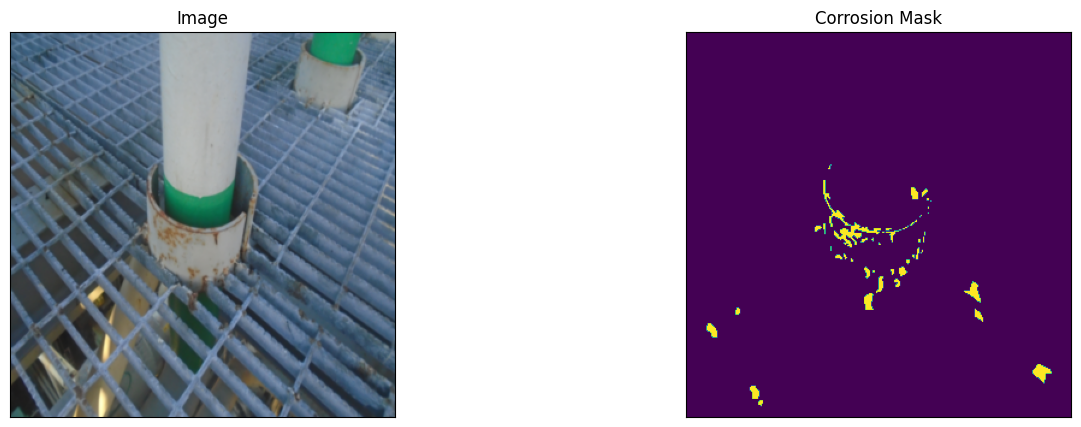

In [26]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['corrosion'])

image, mask = dataset[5] # get some sample
visualize(
    image=image,
    corrosion_mask=mask[..., 0].squeeze(),
)


In [27]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    preprocess_input = sm.get_preprocessing(BACKBONE)

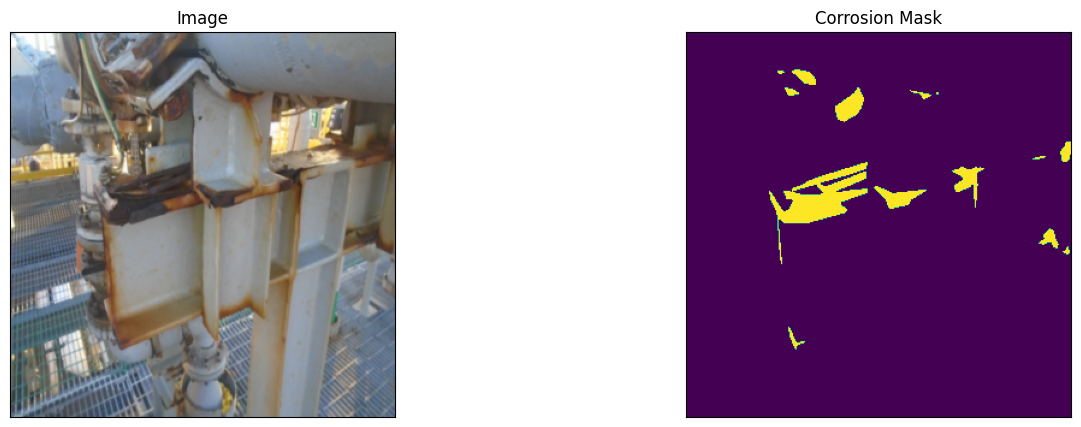

In [28]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['corrosion'], augmentation=None)

image, mask = dataset[12] # get some sample
visualize(
    image=image,
    corrosion_mask=mask[..., 0].squeeze(),
)

In [29]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [30]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')
model_input = model.input
model_output = model.get_layer('final_conv').output #(any layer you want)
#add dropout
model_output = keras.layers.Dropout(0.3)(model_output)
#add activation
output = keras.layers.Activation(activation, name=activation)(model_output)
model_dp = keras.models.Model(model_input, output)
model=model_dp

In [31]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
#dice_loss = sm.losses.DiceLoss()
#focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = sm.losses.DiceLoss()

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [32]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_2[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                         

In [33]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES,
    augmentation=None,
    preprocessing=None,
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES,
    augmentation=None,
    preprocessing=None,
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Segmentation_Models_Colab/models/'+MODEL_NAME+'.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

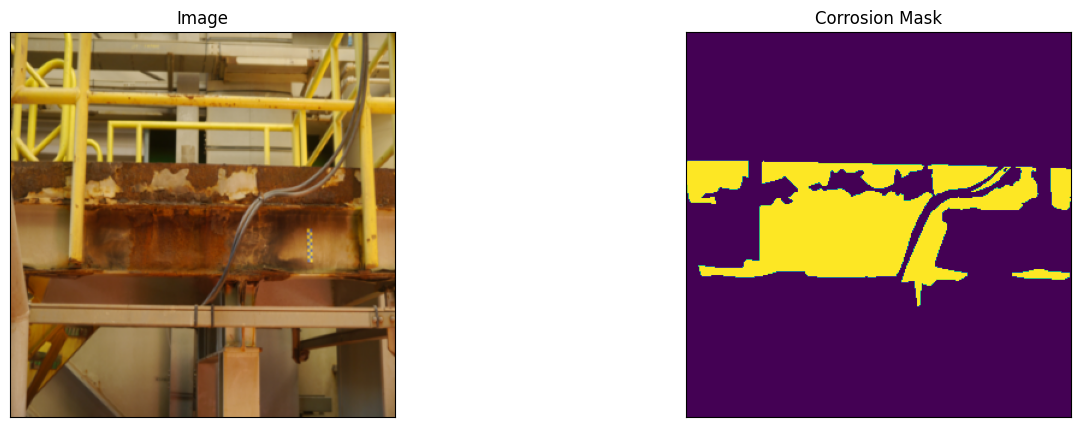

In [34]:
#Lets look at validation data we have
image, mask = valid_dataset[12] # get some sample
visualize(
    image=image,
    corrosion_mask=mask[..., 0].squeeze(),
)

In [35]:
import time
import pandas as pd
start = time.time()

In [36]:
# train model
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)

Epoch 1/80
112/112 [==============================] - 131s 471ms/step - loss: 0.7803 - iou_score: 0.2288 - f1-score: 0.3536 - val_loss: 0.8516 - val_iou_score: 0.1907 - val_f1-score: 0.2949 - lr: 1.0000e-04
Epoch 2/80
112/112 [==============================] - 49s 438ms/step - loss: 0.7041 - iou_score: 0.3826 - f1-score: 0.5401 - val_loss: 0.7612 - val_iou_score: 0.3201 - val_f1-score: 0.4430 - lr: 1.0000e-04
Epoch 3/80
112/112 [==============================] - 48s 431ms/step - loss: 0.6763 - iou_score: 0.4351 - f1-score: 0.5947 - val_loss: 0.7004 - val_iou_score: 0.3851 - val_f1-score: 0.5108 - lr: 1.0000e-04
Epoch 4/80
112/112 [==============================] - 51s 450ms/step - loss: 0.6608 - iou_score: 0.4692 - f1-score: 0.6283 - val_loss: 0.6750 - val_iou_score: 0.3675 - val_f1-score: 0.4957 - lr: 1.0000e-04
Epoch 5/80
112/112 [==============================] - 49s 432ms/step - loss: 0.6527 - iou_score: 0.4886 - f1-score: 0.6470 - val_loss: 0.6370 - val_iou_score: 0.3846 - val_f1-

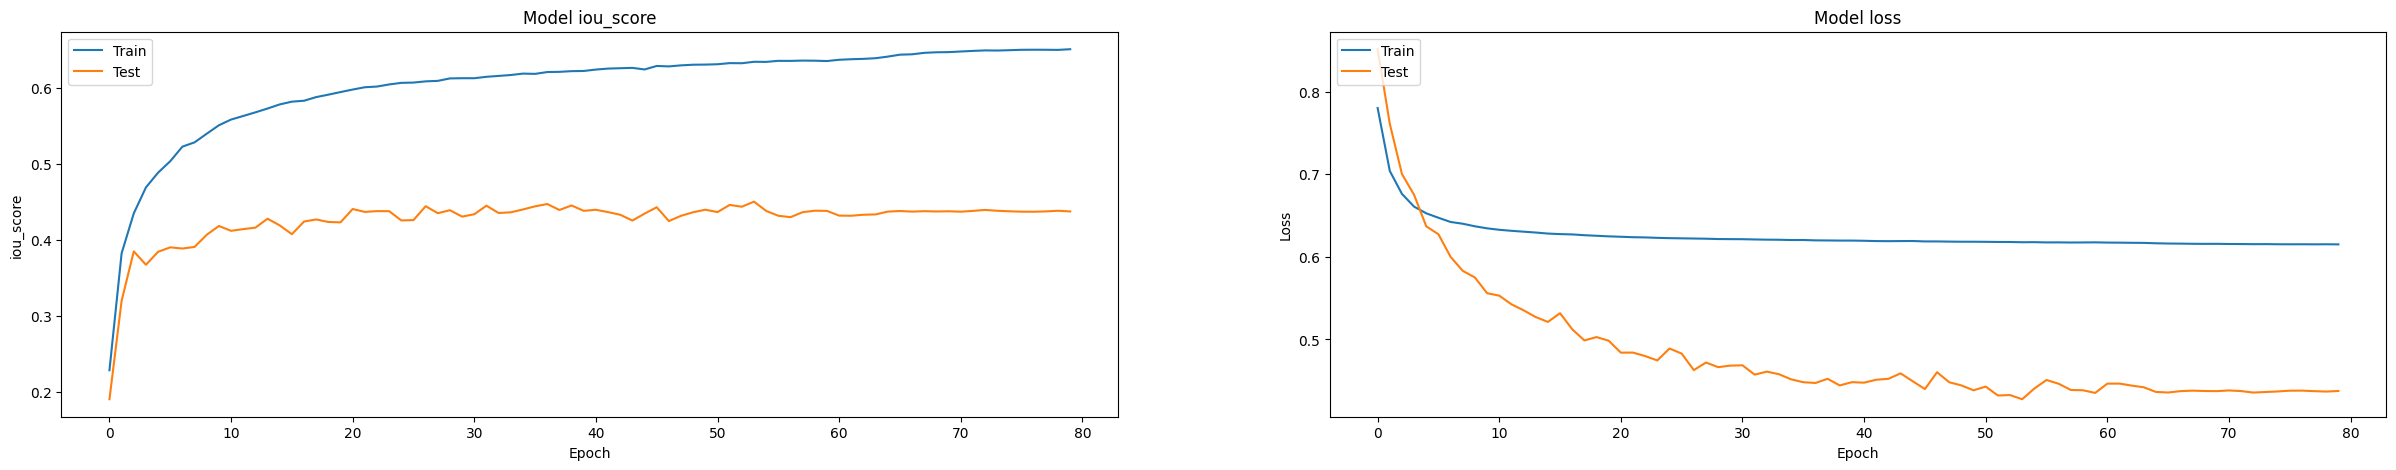

In [37]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.savefig('/content/drive/My Drive/Segmentation_Models_Colab/graficos/'+MODEL_NAME+'.PNG')
plt.show()


In [38]:
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
    augmentation=None,
    preprocessing=None,
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

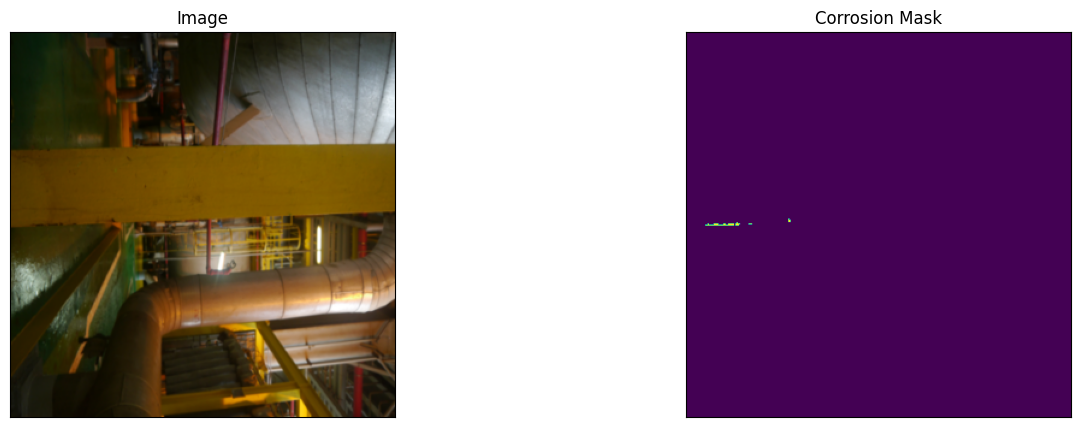

In [39]:
#Lets look at test data we have

image, mask = test_dataset[9] # get some sample
visualize(
    image=image,
    corrosion_mask=mask[..., 0].squeeze(),
)

In [40]:
# load best weights
model.load_weights('/content/drive/My Drive/Segmentation_Models_Colab/models/'+MODEL_NAME+'.h5')

In [ ]:

scores = model.evaluate_generator(test_dataloader)

print("Total time: ", time.time() - start, "seconds")
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [ ]:
df=pd.DataFrame({'Train_IoU' : history.history['iou_score'],'Val_IoU' : history.history['val_iou_score'] }, columns=['Train_IoU','Val_IoU'])
df.to_excel('/content/drive/My Drive/Segmentation_Models_Colab/callbacks/'+MODEL_NAME+'.xlsx')

In [ ]:
ids = np.arange(len(test_dataset))

for i in ids:

    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
